# Tutorial HallThruster.jl

HallThruster is an efficient 1D fluid model to simulate Hall Thruster discharges. 
This tutorial will show you how to get started with HallThruster.jl and will compare our results to the Landmark study. Detailed information can be found in the [Documentation](https://um-pepl.github.io/HallThruster.jl/dev/).

First install HallThruster.jl according to the Readme instructions. Then load it:

In [1]:
using HallThruster

┌ Warning: Package HallThruster does not have Test in its dependencies:
│ - If you have HallThruster checked out for development and have
│   added Test as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with HallThruster
└ Loading Test into HallThruster from project dependency, future warnings for HallThruster are suppressed.
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



Let's also load Plots for visualization:

In [2]:
using Plots

Let's try and replicate the LANDMARK benchmarks. 

Let us define the following `run_sim()` as a helper function. The most important arguments are `end_time; ncells, nsave, dt`. When increasing the amount of cells, the timestep has to be reduced accordingly to satisfy the CFL condition. `nsave` specifies the amount of times the solution is saved in constant time intervals. 

Here we have the Landmark source terms and energy loss terms given as a standard, and we can select one of the 3 test cases to run. We initialize a new simulation and define the domain as twice the thruster length, as evident by the argument `L = 0.05`. The default flux is set to `rusanov` and the time marching algorithm from DifferentialEquations.jl for the heavy species is a strong stability preserving Runge Kutta scheme of second order `SSPRK22`. 

In [3]:
function run_sim(end_time = 0.0002; ncells = 50, nsave = 2, dt = 1e-8,
        implicit_energy = 1.0, reconstruct = false, limiter = HallThruster.osher,
        restart_file = nothing, case = 1, flux = HallThruster.rusanov, ionization_model = HallThruster.LandmarkIonizationLookup(), transition = HallThruster.LinearTransition(0.001, 0.0),
        electron_neutral_model = HallThruster.LandmarkElectronNeutral(), coupled = true, energy_equation = :LANDMARK,
        progress_interval = 0, WENO = false, L = 0.05
    )

    domain = (0.0, L)

    #Landmark cases loss frequencies
    αϵ_in, αϵ_out = if case == 1
        (1.0, 1.0)
    elseif case == 2
        (0.5, 1.0)
    elseif case == 3
        (0.4, 1.0)
    end

    scheme = HallThruster.HyperbolicScheme(flux, limiter, reconstruct, WENO)

    ϵ_anode = 3.0
    ϵ_cathode = 3.0

    config = HallThruster.Config(;
        ncharge = 1,
        anode_Te = 2/3 * ϵ_anode,
        cathode_Te = 2/3 * ϵ_cathode,
        discharge_voltage = 300.0,
        excitation_model = HallThruster.LandmarkExcitationLookup(),
        wall_loss_model = HallThruster.ConstantSheathPotential(-20, αϵ_in, αϵ_out),
        wall_collision_freq = 1.0 * 1e7,
        implicit_energy = implicit_energy,
        transition_function = transition,
        electron_pressure_coupled = coupled,
        progress_interval = progress_interval,
        neutral_velocity = 150.0,
        neutral_temperature = 0.0,
        ion_temperature = 0.0,
        thruster = HallThruster.SPT_100,
        anode_mass_flow_rate = 5e-6,
        scheme,
        electron_neutral_model,
        ionization_model,
        domain,
        energy_equation,
        WENO = WENO
    )

    @time sol = HallThruster.run_simulation(config, dt, end_time, ncells, nsave; restart_file)
    return sol
end

run_sim (generic function with 2 methods)

Now we can use `run_sim()` to perform simulations. 

In [4]:
sol = run_sim(1e-3; ncells=200, nsave=1000, case = 1, dt = 0.7e-8);

 41.119670 seconds (11.41 M allocations: 685.340 MiB, 0.65% gc time, 23.41% compilation time)


`sol` is a `HallThrusterSolution` object. This mimics a standard DifferentialEquations `ODESolution` object and has the following fields
- `u`: A vector of solution matrices of length `nsave`. This contains the main state variables: $\rho_n$, $\rho_i$, $\rho_i u_i$, and $n_e\epsilon$
- `savevals`: A vector of NamedTuples containing some auxilliary variables including $\phi$, $n_e$, $Tev$, $\nu_{AN}$ , $\nu_{en}$, $\nu_{ei}$, and $\mu$

HallThruster has some built-in plotting and postprocessing faculties. Firstly, we can type `plot(sol, frame; case)` To plot the solution at the given frame (from 1 to nsave) and (optionally) compare to the LANDMARK benchmarks.

┌ Warning: File landmark\case_1\neutral_density_fluid_1.csv not found, skipping plot.
└ @ HallThruster C:\Users\thoma\.julia\packages\HallThruster\IhOuM\src\plotting.jl:49
┌ Warning: File landmark\case_1\neutral_density_fluid_2.csv not found, skipping plot.
└ @ HallThruster C:\Users\thoma\.julia\packages\HallThruster\IhOuM\src\plotting.jl:49
┌ Warning: File landmark\case_1\neutral_density_hybrid.csv not found, skipping plot.
└ @ HallThruster C:\Users\thoma\.julia\packages\HallThruster\IhOuM\src\plotting.jl:49
┌ Warning: File landmark\case_1\plasma_density_fluid_1.csv not found, skipping plot.
└ @ HallThruster C:\Users\thoma\.julia\packages\HallThruster\IhOuM\src\plotting.jl:49
┌ Warning: File landmark\case_1\plasma_density_fluid_2.csv not found, skipping plot.
└ @ HallThruster C:\Users\thoma\.julia\packages\HallThruster\IhOuM\src\plotting.jl:49
┌ Warning: File landmark\case_1\plasma_density_hybrid.csv not found, skipping plot.
└ @ HallThruster C:\Users\thoma\.julia\packages\HallThruste

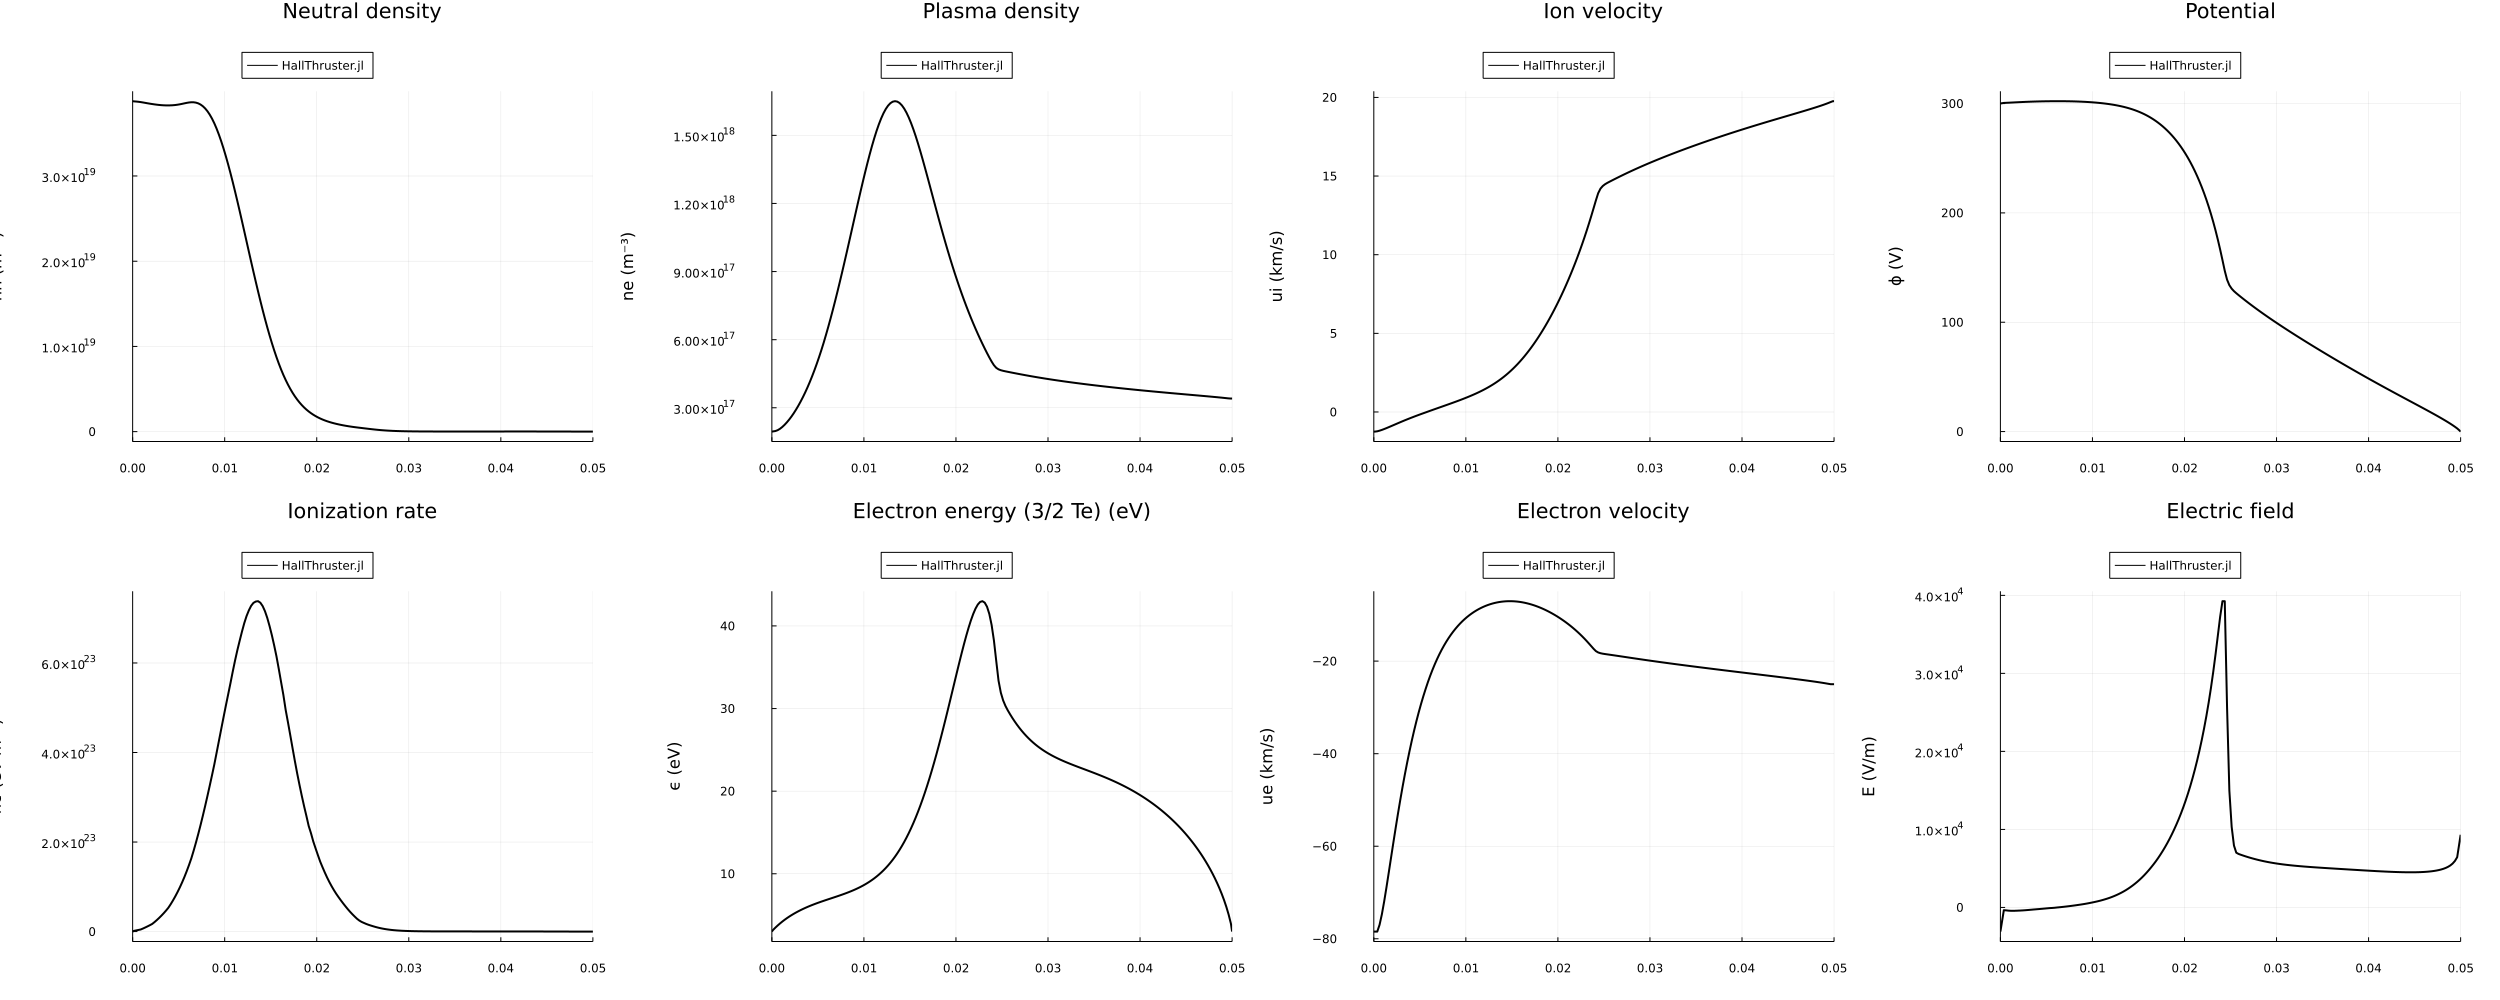

In [5]:
HallThruster.plot(sol; case = 1)